In [1]:
from qiskit import schedule
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.test.mock import FakeMumbai
backend = FakeMumbai()

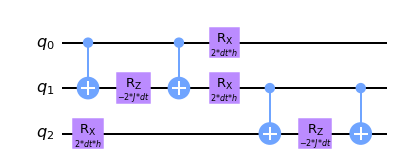

In [2]:
# Latex-like symbols only supported by current versions of my PR 6899 (in template optimization)
JJ = Parameter('$J$') # exchange coupling strength
hh = Parameter('$h$') # transverse magnetic field
dt = Parameter('$dt$') # Trotter step size
TT = Parameter('$T$') # total time

qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.rz(-2*JJ*dt, 1)
qc.cx(0, 1)
qc.rx(2*hh*dt, [0, 1, 2])
qc.cx(1, 2)
qc.rz(-2*JJ*dt, 2)
qc.cx(1, 2)
qc.draw(output='mpl')

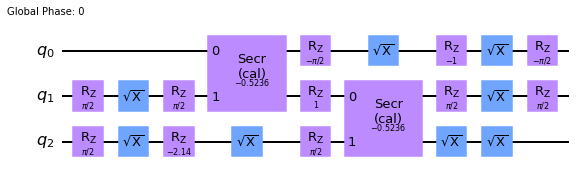

In [3]:
from qiskit_research.utils.pulse_scaling import scale_cr_pulses
#new_qc = scale_cr_pulses(qc, backend)
new_qc = scale_cr_pulses(qc, backend, {JJ: 0.5236, hh: 1, dt: 0.5})
new_qc.draw('mpl')

In [4]:
new_sched = schedule(new_qc, backend)

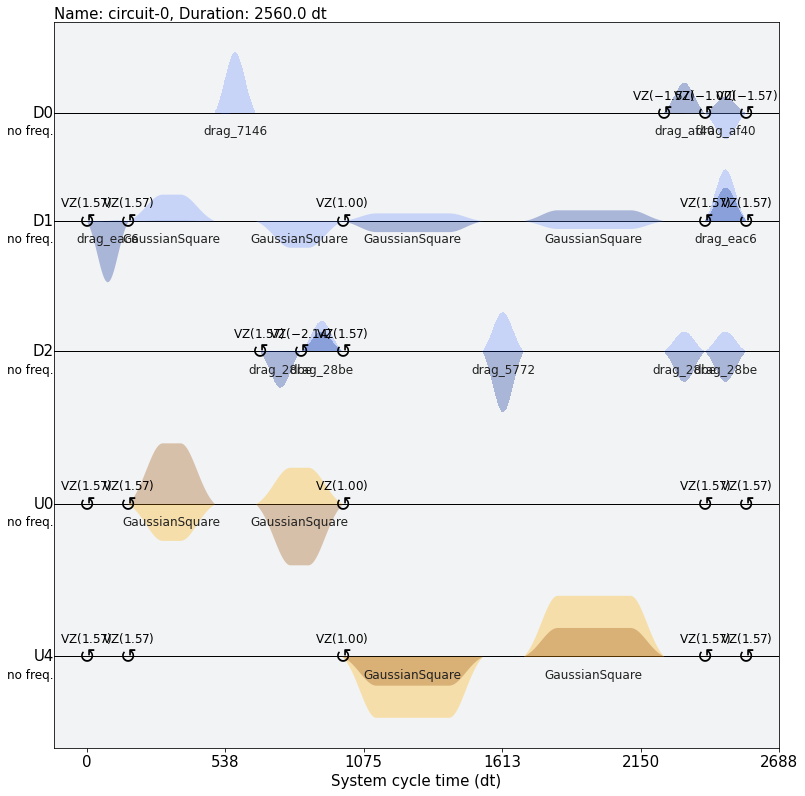

In [5]:
new_sched.draw()

## The following are calculations of decompositions 

In [6]:
from qiskit.circuit import QuantumRegister
from qiskit.circuit.library import RXGate, RYGate, RZGate, SXGate
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.qasm import pi
from qiskit.quantum_info import Operator

In [7]:
# check this decomposition corrspons to a general RXGate

decomp1 = QuantumCircuit(1)
decomp1.rz(pi/2, 0)
decomp1.sx(0)
decomp1.rz(pi + pi/3, 0)
decomp1.sx(0)
decomp1.rz(pi/2, 0)

In [8]:
qc1 = QuantumCircuit(1)
qc1.rx(pi/3, 0)

In [9]:
Operator(qc1).equiv(Operator(decomp1))

True

In [10]:
# check this decomposition corrspons to a general RYGate

decomp2 = QuantumCircuit(1)
decomp2.sx(0)
decomp2.rz(pi + pi/3, 0)
decomp2.sx(0)
decomp2.rz(pi, 0)

In [11]:
qc2 = QuantumCircuit(1)
qc2.ry(pi/3, 0)

In [12]:
Operator(qc2).equiv(Operator(decomp2))

True

In [13]:
# try adding decomposition to session equivalence library

q = QuantumRegister(1, "q")
theta = Parameter("theta")
def_rx = QuantumCircuit(q)
def_rx.append(RZGate(pi/2), [q[0]], [])
def_rx.append(SXGate(), [q[0]], [])
def_rx.append(RZGate(pi + theta), [q[0]], [])
def_rx.append(SXGate(), [q[0]], [])
def_rx.append(RZGate(pi/2), [q[0]], [])
sel.add_equivalence(RXGate(theta), def_rx)

In [14]:
RXGate(theta).decompositions[0].draw()
#RXGate(theta).decompositions[1].draw()

┌─────────┐┌────┐┌───────────────┐┌────┐┌─────────┐
q: ┤ Rz(π/2) ├┤ √X ├┤ Rz(theta + π) ├┤ √X ├┤ Rz(π/2) ├
   └─────────┘└────┘└───────────────┘└────┘└─────────┘

In [15]:
# forward ecr

qc = 0
qt = 1

cx_f_sched = QuantumCircuit(2)
cx_f_sched.cx(qc, qt)

rzx_f_sched = QuantumCircuit(2)
rzx_f_sched.sdg(qc)
rzx_f_sched.y(qc)
rzx_f_sched.sx(qt)

# begin ecr
rzx_f_sched.rzx(pi/2, qc, qt)
rzx_f_sched.x(qc) # echo control back
# end ecr

In [16]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
cx_01 = backend.defaults().instruction_schedule_map.get('cx', qubits=[0, 1])
cx_10 = backend.defaults().instruction_schedule_map.get('cx', qubits=[1, 0])

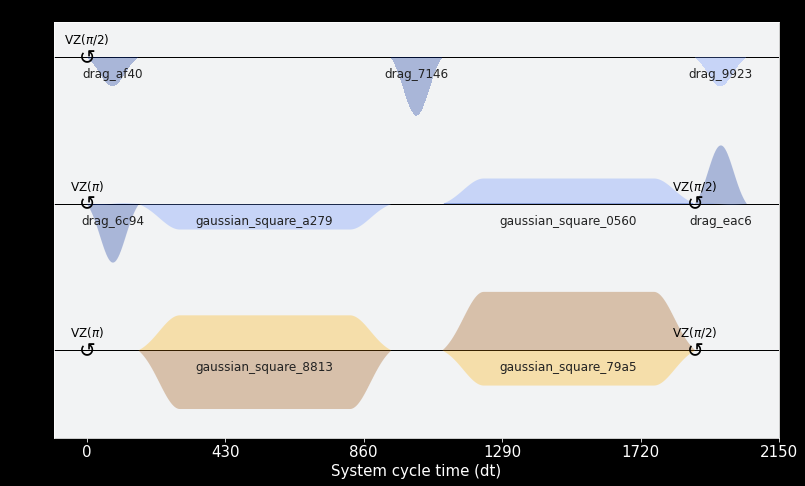

In [17]:
cx_10.draw()

In [18]:
Operator(rzx_f_sched).equiv(Operator(cx_f_sched))

True

In [19]:
# reverse ecr

cx_r_sched = QuantumCircuit(2)
cx_r_sched.cx(qt, qc)

rzx_r_sched = QuantumCircuit(2)
rzx_r_sched.s(qc)
rzx_r_sched.sx(qc)
rzx_r_sched.z(qt)
rzx_r_sched.ry(pi/2, qt)

# begin ecr
rzx_r_sched.rzx(pi/2, qc, qt) # forward ecr (reverse of CNOT direction)
rzx_r_sched.x(qc) # echo target back
# end ecr

rzx_r_sched.ry(-pi/2, qc)
rzx_r_sched.s(qt)
rzx_r_sched.sx(qt)

In [20]:
cx_r_sched.draw()

┌───┐
q_0: ┤ X ├
     └─┬─┘
q_1: ──■──

In [21]:
Operator(rzx_r_sched).equiv(Operator(cx_r_sched))

True

In [22]:
# rzx in terms of rxz

rzx = QuantumCircuit(2)
rzx.h(0)
rzx.h(1)
rzx.rzx(pi/3, 0, 1)
rzx.h(0)
rzx.h(1)

rxz = QuantumCircuit(2)
rxz.rzx(pi/3, 1, 0)

In [23]:
Operator(rzx).equiv(Operator(rxz))

True

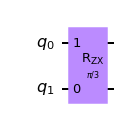

In [24]:
rxz.draw('mpl')

In [25]:
import qiskit.tools.jupyter
%qiskit_version_table